In [1]:
JETNET=True
if JETNET:
    from dataloader_jetnet import PointCloudDataloader
    import jetnet
    run="zjf03vmr"
    name="jet"
    run="jx18edcf"
    name="MDMA_jet"

else:
    from dataloader_calo import PointCloudDataloader
    name="calo"


In [2]:

from torch.nn import functional as FF
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import BatchSampler, DataLoader, Dataset, Sampler
from tqdm import tqdm

import wandb
ckpt=f"/gpfs/dust/maxwell/user/kaechben/calochallenge/{name}/{run}/checkpoints/"
end="epoch=914-w1m=0.00045-fpd=0.00024.ckpt"
end="epoch=2178-w1m=0.00036-fpd=0.00029-v1.ckpt"
ckpt=ckpt+end
api=wandb.Api()
run=api.run(f"kaechben/{name}/{run}")
config=run.config

In [5]:

class CloudNorm(nn.Module):
    def __init__(self, eps=1e-5):
        super(CloudNorm, self).__init__()
        self.eps = eps

    def forward(self, point_cloud, mask=None):
        """
        :param point_cloud: Tensor of shape (B, N, D)
        :param mask: Boolean tensor of the same shape as point_cloud indicating valid points
        :return: Normalized point cloud
        """
        if mask is None:
            mask = torch.zeros_like(point_cloud, dtype=torch.bool)
        mask=~mask
        # Create a masked version of the point cloud
        masked_point_cloud = point_cloud * mask.unsqueeze(-1).float()

        # Calculate mean and std dev only for valid points
        sum_points = masked_point_cloud.sum(dim=1, keepdim=False)
        num_valid_points = mask.float().sum(dim=1, keepdim=False)
        mean = sum_points / num_valid_points.unsqueeze(-1)

        variance = ((point_cloud - mean.unsqueeze(1)) ** 2 * mask.unsqueeze(-1).float()).sum(dim=1, keepdim=True) / num_valid_points.unsqueeze(-1).unsqueeze(-1)
        std = torch.sqrt(variance)

        # Normalize the point cloud
        normalized_point_cloud = (point_cloud - mean.unsqueeze(1)) / (std + self.eps)

        # Zero out the points that are masked
        normalized_point_cloud = normalized_point_cloud * mask.unsqueeze(-1).float()

        return normalized_point_cloud


class Block(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden,dropout,weightnorm=True,cond_dim=1,glu=False,cloudnorm=False):
        super().__init__()
        self.fc0 = WeightNormalizedLinear(embed_dim, hidden) if weightnorm else nn.Linear(embed_dim, hidden)
        self.fc0_cls = (WeightNormalizedLinear(embed_dim, hidden)) if weightnorm else nn.Linear(embed_dim, hidden)
        self.fc1 = (WeightNormalizedLinear(hidden*2, embed_dim)) if weightnorm else nn.Linear(hidden*2, embed_dim)
        self.glu=glu
        self.cloudnorm=CloudNorm() if cloudnorm else None
        self.fc1_cls = (WeightNormalizedLinear(hidden+1, hidden)) if weightnorm else nn.Linear(hidden+1, hidden)
        self.fc2_cls = (WeightNormalizedLinear(hidden, embed_dim)) if weightnorm else nn.Linear(hidden, embed_dim)
        self.cond_cls = nn.Linear(cond_dim, embed_dim)
        self.attn = weight_norm(nn.MultiheadAttention(hidden, num_heads, batch_first=True, dropout=dropout),"in_proj_weight") if weightnorm else nn.MultiheadAttention(hidden, num_heads, batch_first=True, dropout=dropout)
        self.act = nn.LeakyReLU()
        self.ln = nn.LayerNorm(hidden)


    def forward(self, x, x_cls,cond, mask):
        res = x.clone()
        res_cls = x_cls.clone()
        x = self.fc0(self.act(x))
        if self.cloudnorm:
            x = self.cloudnorm(x,mask)
        x_cls = self.ln(self.fc0(self.act(x_cls)))
        x_cls,w = self.attn(x_cls, x, x, key_padding_mask=mask,need_weights=False)

        x_cls =self.fc1_cls(torch.cat((x_cls,cond[:,:,-1:]),dim=-1))#+res_cls#+x.mean(dim=1).
        if self.glu:
            x_cls = self.act(F.glu(torch.cat((x_cls,self.cond_cls(cond[:,:,:1])),dim=-1)))

        #     x_cls = self.act(self.fc1_cls((x_cls)))#+x.mean(dim=1).
        #     x_cls = self.act(F.glu(torch.cat((x_cls,self.cond_cls(cond)),dim=-1)))
        x = self.fc1(torch.cat((x,x_cls.expand(-1,x.shape[1],-1)),dim=-1))+res
        x_cls=self.act(self.fc2_cls(x_cls))
        #x_cls =x_cls+res_cls
        #x=F.glu(torch.cat((x,self.cond(cond[:,:,:1]).expand(-1,x.shape[1],-1)),dim=-1))
        return x,x_cls,w



class Gen(nn.Module):
    def __init__(self, n_dim, l_dim_gen, hidden_gen, num_layers_gen, heads_gen, cond_dim,cloudnormgen, **kwargs):
        super().__init__()
        self.embbed = nn.Linear(n_dim, l_dim_gen)
        self.encoder = nn.ModuleList([Block(embed_dim=l_dim_gen, num_heads=heads_gen,hidden=hidden_gen,weightnorm=False,dropout=0,cloudnorm=cloudnormgen) for i in range(num_layers_gen)])
        self.out = nn.Linear(l_dim_gen, n_dim)
        self.act = nn.LeakyReLU()
        if cond_dim>1:
            self.cond = nn.Linear(1, l_dim_gen)
        else:
            self.cond = None

    def forward(self, x,mask,cond,weight=False):
        x = self.act(self.embbed(x))
        x_cls = x.sum(1).unsqueeze(1).clone()/self.avg_n
        for layer in self.encoder:
            x, x_cls, w = layer(x,x_cls=x_cls,mask=mask,cond=cond)

        if self.cond:
            x=F.glu(torch.cat((x,self.cond(cond[:,:,:1]).expand(-1,x.shape[1],-1)),dim=-1))
        x= self.out(self.act(x))
        return x



class Disc(nn.Module):
    def __init__(self, n_dim, l_dim, hidden, num_layers, heads,dropout,cond_dim,weightnorm,cloudnorm, **kwargs):
        super().__init__()
        self.embbed = WeightNormalizedLinear(n_dim, l_dim) if weightnorm else spectral_norm(nn.Linear(n_dim, l_dim))
        self.encoder = nn.ModuleList([Block(embed_dim=l_dim, num_heads=heads, hidden=hidden,dropout=dropout,weightnorm=weightnorm,cloudnorm=cloudnorm) for i in range(num_layers)])
        self.out = WeightNormalizedLinear(l_dim, 1) if weightnorm else spectral_norm(nn.Linear(l_dim, 1))
        self.cond = True if cond_dim>1 else False
        self.embbed_cls = WeightNormalizedLinear(l_dim+int(self.cond), l_dim) if weightnorm else spectral_norm(nn.Linear(l_dim+int(self.cond), l_dim))
        self.act = nn.LeakyReLU()
        self.fc1 = WeightNormalizedLinear(l_dim+cond_dim, hidden) if weightnorm else nn.Linear(l_dim+cond_dim, hidden)
        self.fc2 = WeightNormalizedLinear(hidden, l_dim) if weightnorm else nn.Linear(hidden, l_dim)
        self.ln = nn.LayerNorm(l_dim)
        if not weightnorm:

            for module in self.encoder:
                for name,submodule in module.named_children():
                    if isinstance(submodule,nn.Linear):
                        setattr(module,name,spectral_norm(submodule))
                    if isinstance(submodule,nn.MultiheadAttention):
                        setattr(module,name,spectral_norm(submodule,"in_proj_weight"))

    def forward(self, x, mask,cond,weight=False):#mean_field=False

        x = self.act(self.embbed(x))
        x_cls = torch.cat(((x.sum(1)/self.avg_n).unsqueeze(1).clone(),cond),dim=-1) if self.cond else (x.sum(1)/self.avg_n).unsqueeze(1).clone()
        x_cls = self.act(self.embbed_cls(x_cls))
        for layer in self.encoder:
            x,x_cls,w = layer(x, x_cls=x_cls, mask=mask,cond=cond)
            mean_field=x_cls.clone()
        x_cls = self.act(self.fc2(self.act(self.fc1(self.act(torch.cat((x_cls,cond),dim=-1))))))
        return self.out(x_cls),mean_field

/gpfs/dust/maxwell/user/kaechben/.conda/envs/torch2_jetnet/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/dust/maxwell/user/kaechben/.conda/envs/torch2_ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/dust/maxwell/user/kaechben/.conda/envs/torch2_jetnet/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unles

Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]sample lengths: 50000 50000
0.0004198334946536926


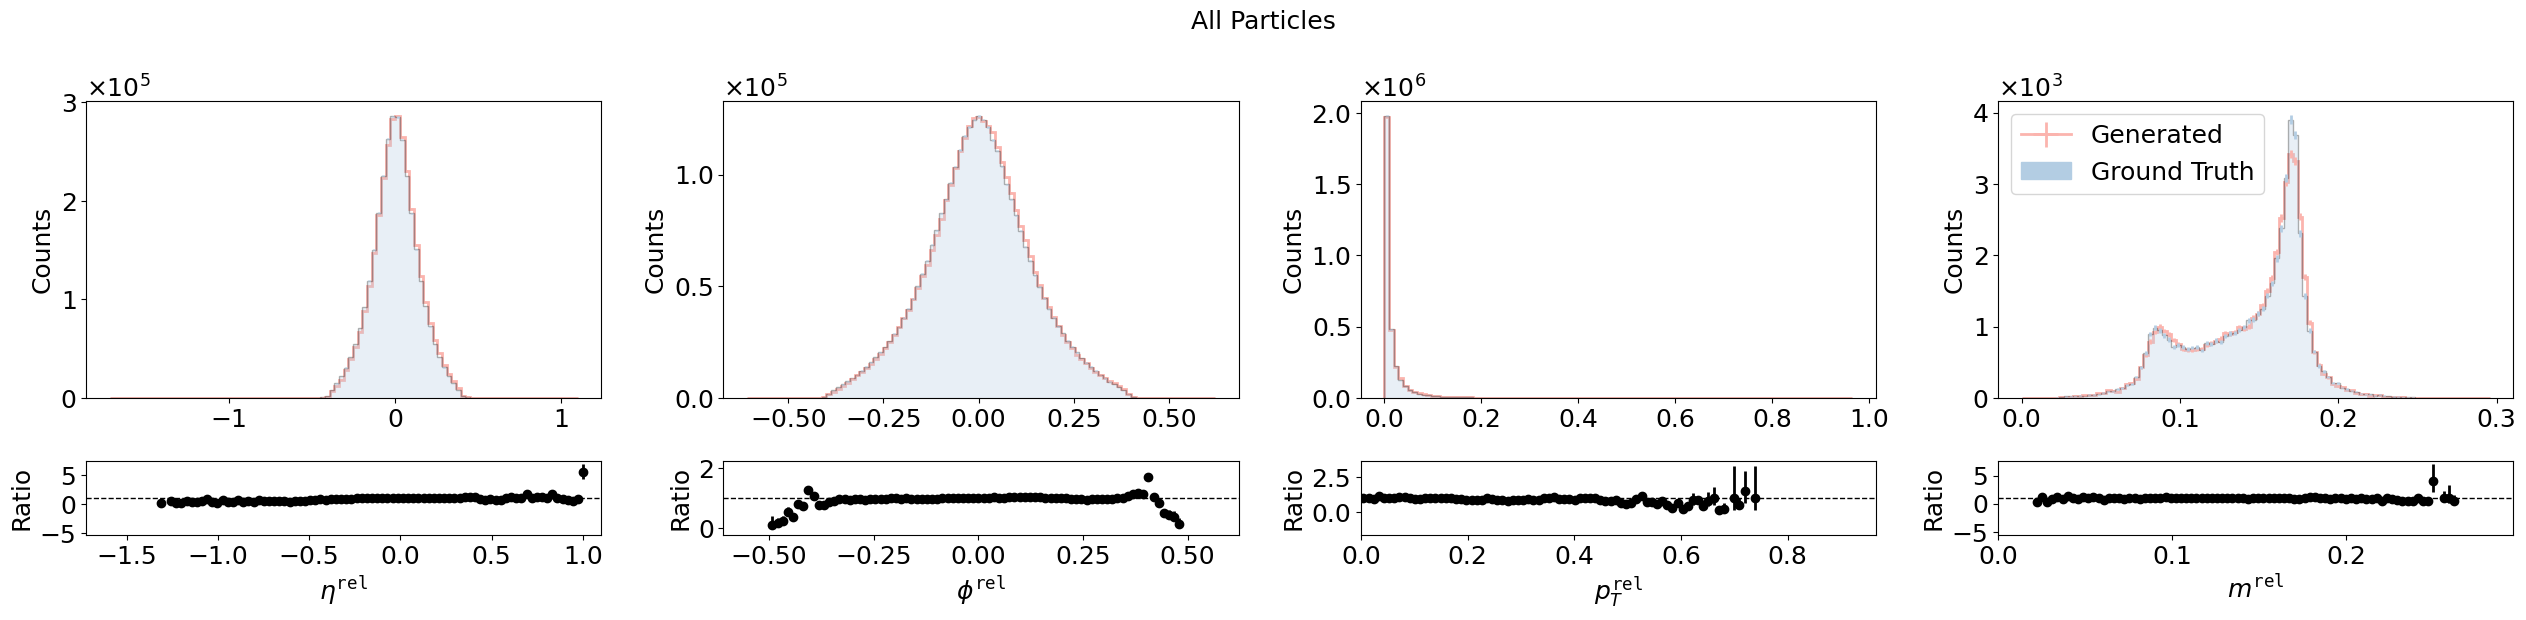

Validation DataLoader 0: 100%|██████████| 4/4 [17:03<00:00, 255.87s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        actual_fpd         │   0.0002908103227101012   │
│         best_w1m          │   0.0004198334946536926   │
│            fpd            │   0.0002908103227101012   │
│            w1m            │   0.0004198334946536926   │
└───────────────────────────┴───────────────────────────┘

[{'w1m': 0.0004198334946536926,
  'actual_fpd': 0.0002908103227101012,
  'best_w1m': 0.0004198334946536926,
  'fpd': 0.0002908103227101012}]

In [3]:

# def on_validation_epoch_start(self, *args, **kwargs):

#     self.gen_net.train()
#     self.dis_net.train()
#     # self.scaler.to(self.device)
#     hists=get_hists(self.hparams.bins,self.scaled_mins.reshape(-1)*0.99,self.scaled_maxs.reshape(-1)*1.01,calo=self.name=="calo")
#     self.hists_real,self.hists_fake=hists["hists_real"],hists["hists_fake"]
#     if self.name=="calo":
#         self.weighted_hists_real,self.weighted_hists_fake=hists["weighted_hists_real"], hists["weighted_hists_fake"]
#         self.response_real, self.response_fake = hists["response_real"], hists["response_fake"]



from fit import MDMA
import pytorch_lightning as pl
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.weight_norm as weight_norm
from torch.nn import Parameter

from helpers import TPReLU, WeightNormalizedLinear
config["sampler"]=False
data_module = PointCloudDataloader(**config)
data_module.setup("fit")
config["L2"]=False
model =MDMA.load_from_checkpoint(ckpt,**config)
model.bins=[100,100,100]
model.n_dim = 3
model.scaler=data_module.scaler
model.w1m_best=0.01
model.min_pt=data_module.min_pt
model.max_pt=data_module.max_pt
mins=torch.ones(config["n_dim"]).unsqueeze(0)
maxs=torch.ones(config["n_dim"]).unsqueeze(0)
n=[]
for i in data_module.train_dataloader():
    mins=torch.min(torch.cat((mins,i[0][~i[1]].min(0,keepdim=True)[0]),dim=0),dim=0)[0].unsqueeze(0)
    maxs=torch.max(torch.cat((maxs,i[0][~i[1]].max(0,keepdim=True)[0]),dim=0),dim=0)[0].unsqueeze(0)
    n.append((~i[1]).sum(1))
model.maxs=maxs.cuda()
model.mins=mins.cuda()
model.avg_n=torch.cat(n,dim=0).float().cuda().mean()
model.gen_net.avg_n=torch.cat(n,dim=0).float().cuda().mean()
model.dis_net.avg_n=torch.cat(n,dim=0).float().cuda().mean()
model.swa=False
model.scaler.to(model.device)
model.scaled_mins=torch.tensor(data_module.mins).cuda()
model.scaled_maxs=torch.tensor(data_module.maxs).cuda()
# model.on_validation_epoch_start=on_validation_epoch_start
trainer = pl.Trainer(
        devices=1,
        accelerator="gpu",
    )
trainer.validate(model, dataloaders=data_module.test_dataloader())

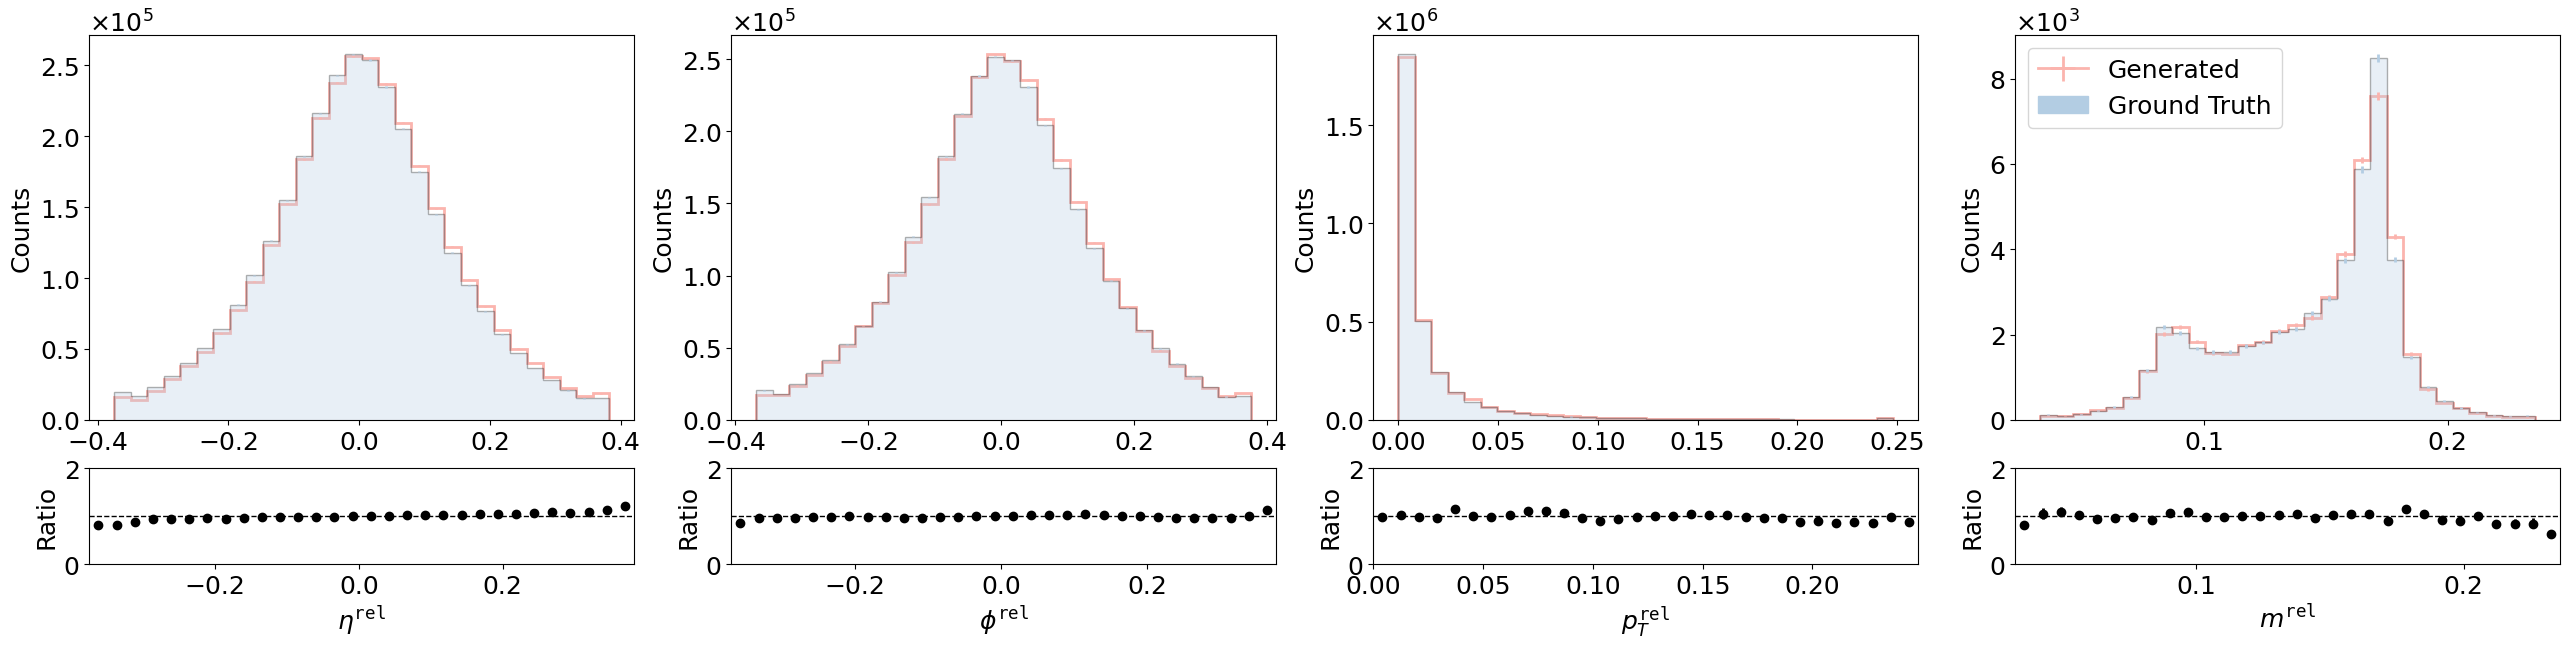

In [4]:

class plotting_point_cloud():
    '''This is a class that takes care of  plotting steps in the script,
        It is initialized with the following arguments:
        true=the simulated data, note that it needs to be scaled
        gen= Generated data , needs to be scaled
        step=The current step of the training, this is need for tensorboard
        model=the model that is trained, a bit of an overkill as it is only used to access the losses
        config=the config used for training
        logger=The logger used for tensorboard logging'''
    def __init__(self,step=None,logger=None,weight=1):

        self.step=step

        self.weight=weight
        self.fig_size1=[6.4, 6.4]
        self.fig_size2=[2*6.4, 6.4]
        self.fig_size3=[3*6.4, 6.4]
        self.fig_size4=[4*6.4, 6.4]
        self.alpha=0.3
        mpl.rcParams['lines.linewidth'] = 2
        font = { "size": 18}#"family": "normal",
        mpl.rc("font", **font)
        mpl.rc('lines', linewidth=2)
        sns.set_palette("Pastel1")
        if logger is not None:
            self.summary=logger
        else:
            self.summary = None
    def plot_ratio(self,h_real,h_fake,weighted,leg=-1):
        i = 0
        k = 0
        fig, ax = plt.subplots(2, 4, gridspec_kw={"height_ratios": [4, 1]}, figsize=self.fig_size4)
        # plt.suptitle("All Particles", fontsize=18)
        for v, name in zip(["eta", "phi", "pt", "m"], [r"$\eta^{\tt rel}$", r"$\phi^{\tt rel}$", r"$p_T^{\tt rel}$", r"$m^{\tt rel}$"]):


            main_ax_artists, sublot_ax_arists = h_fake[k].plot_ratio(
            h_real[k],
            ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
            rp_ylabel=r"Ratio",
            bar_="blue",
            rp_num_label="Generated",
            rp_denom_label="Ground Truth",
            rp_uncert_draw_type="line",  # line or bar)
            )
            i += 1
            ax[0, k].set_xlabel("")
            ax[0, k].patches[1].set_fill(True)
            ax[0, k].ticklabel_format(axis="y", style="scientific", scilimits=(-3, 3), useMathText=True)
            ax[0, k].patches[1].set_fc(sns.color_palette()[1])
            ax[0, k].patches[1].set_edgecolor("black")
            ax[0, k].patches[1].set_alpha(self.alpha)
            ax[1, k].set_xlabel(name)
            ax[0, k].set_ylabel("Counts")
            ax[1, k].set_ylabel("Ratio")
            ax[0, k].patches[0].set_lw(2)
            ax[0, k].get_legend().remove()
            ax[1,k].set_ylim(0,2)
            # if k<2:
                # ax[0,k].set_xlim(-0.5,0.5)
                # ax[1,k].set_xlim(-0.5,0.5)

            k += 1
            
            
        ax[0, leg].legend(loc="best", fontsize=18)
        handles, labels = ax[0, leg].get_legend_handles_labels()
        ax[0, -1].locator_params(nbins=4, axis="x")
        ax[1, -1].locator_params(nbins=4, axis="x")
        handles[1] = mpatches.Patch(color=sns.color_palette()[1], label="The red data")
        ax[0, leg].legend(handles, labels)
        plt.tight_layout(pad=0.2)
        # if not save==None:
        plt.savefig("jetnet.pdf",format="pdf")
        plt.show()
        plt.close()
from helpers import get_hists,mass
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.patches as mpatches
fake=torch.cat(model.fake)
true=torch.cat(model.batch)
m_f,m_t=mass(fake),mass(true)
mins=torch.quantile(torch.cat((fake.reshape(-1,3),true.reshape(-1,3))),0.001,dim=0)
maxs=torch.quantile(torch.cat((fake.reshape(-1,3),true.reshape(-1,3))),0.999,dim=0)
fake=torch.clamp(fake,min=mins,max=maxs)
true=torch.clamp(true,min=mins,max=maxs)
mins=torch.cat((mins,torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0).unsqueeze(0)))
maxs=torch.cat((maxs,torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0).unsqueeze(0)))*1.01
m_f=torch.clamp(m_f,min=torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0),max=torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0))
m_t=torch.clamp(m_t,min=torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0),max=torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0))
hists=get_hists([30,30,30,30],mins,maxs,calo=model.name=="calo")
masks=torch.cat(model.masks) 
for var in range(3):
    hists["hists_real"][var].fill(true.reshape(-1,3)[(true.reshape(-1,3)!=0).all(1)][:,var].cpu().numpy())
    hists["hists_fake"][var].fill(fake.reshape(-1,3)[(fake.reshape(-1,3)!=0).all(1)][:,var].cpu().numpy())
hists["hists_real"][3].fill(m_t.cpu().numpy())
hists["hists_fake"][3].fill(m_f.cpu().numpy())

plot=plotting_point_cloud()
plot.plot_ratio(hists["hists_real"],hists["hists_fake"],weighted=False,leg=-1)

In [5]:
mins

tensor([-0.3747, -0.3687,  0.0000,  0.0326])

In [ ]:
import pickle
import numpy as np
import time
from scipy.stats import wasserstein_distance
from helpers import mass
from jetnet.evaluation import w1m, w1p, w1efp, fpd, kpd,  fpnd, get_fpd_kpd_jet_features
with open("kde/" +"t" + "_kde.pkl", "rb") as f:
    kde = pickle.load(f)
n=5
true=data_module.real_test
with torch.no_grad():
    kde_sample = kde.resample(n * 50000 + 10000).T  # account for cases were kde_sample is not in [1,150]
    z = torch.normal(torch.zeros((250000, 150,3), device="cpu"), torch.ones((250000, 150,3), device="cpu"))
    
    n_sample = np.rint(kde_sample)
    n_sample = torch.tensor(n_sample[(n_sample >= 1) & (n_sample <= 150)]).cuda().long()
    indices = torch.arange(150, device="cuda")
    mask = indices.view(1, -1) < torch.tensor(n_sample).view(-1, 1)
    mask = ~mask.bool()[: len(z)]
    z[mask] = 0
    model.gen_net.cuda()
    cond=(n_sample/model.avg_n).unsqueeze(1).unsqueeze(1)
    start = time.time()
    fake = torch.cat([model.gen_net(z[i * 50000 : (i + 1) * 50000].cuda(), mask=mask[i * 50000 : (i + 1) * 50000].bool().cuda(),cond=cond[i * 50000 : (i + 1) * 50000]).cpu() for i in range(n)], dim=0)
    fake[:,:,:] = model.relu(fake[:, :, :] - model.mins.cpu()) + model.mins.cpu()
    fake[:,:,:] = -model.relu(model.maxs.cpu() - fake[:, :, :]) + model.maxs.cpu()
    fake[mask] = 0  # set the masked values to zero
    
    fake_scaled = model.scaler.inverse_transform(fake).float()
    fake_scaled[mask]=0
    
    print("time pro jet {}".format((time.time() - start) / len(fake)))

    w1m_ = w1m(fake_scaled[:, :, :3], true[:, :, :3], num_eval_samples=len(true),num_batches=16)
    topidx=fake_scaled[:len(true), :, :3].topk(k=30,dim=1,largest=True).indices
    topidx_real=true[:, :, :3].topk(k=30,dim=1,largest=True).indices
    highptjets = torch.stack([jet[idx] for jet, idx in zip(fake_scaled[:len(true), :, :3], topidx)])
    highptjets_real = torch.stack([jet[idx] for jet, idx in zip(true, topidx_real)])
    # print("fpnd:",fpnd(highptjets,highptjets_real,))
    kpd_real = get_fpd_kpd_jet_features(true, efp_jobs=20)
    kpd_fake = get_fpd_kpd_jet_features(fake_scaled[: len(true)], efp_jobs=20)

    kpd_ = kpd(kpd_real, kpd_fake)
    fpd_ = fpd(kpd_real, kpd_fake, min_samples=10000, max_samples=len(true))
    data_ms = mass(true).numpy()
    i = 0
    w_dist_list = []
    for _ in range(n):
        gen_ms = mass(fake_scaled[i : i + len(true)]).numpy()
        i += len(true)
        w_dist_ms = wasserstein_distance(data_ms, gen_ms)
        w_dist_list.append(w_dist_ms)
    w1m_2 = np.mean(np.array(w_dist_list))
    w1m_2std = np.std(np.array(w_dist_list))

    w1efp_ = w1efp(fake_scaled[: len(true)], true[:, :, :3], num_eval_samples=len(true), efp_jobs=20)
    w1p_ = w1p(fake_scaled, true[:, :, :3], num_eval_samples=len(true))

    config = {"name": ["t"], "model": [name], "w1m": [w1m_], "w1p": [w1p_],  "w1m_2": [(w1m_2, w1m_2std)],"w1efp": [w1efp_], "kpd": [kpd_], "fpd": [fpd_]}#"w1efp": [w1efp_], "kpd": [kpd_], "fpd": [fpd_]
    print(config)


/tmp/ipykernel_147247/1571194572.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = indices.view(1, -1) < torch.tensor(n_sample).view(-1, 1)


time pro jet 1.579738998413086e-05


KeyboardInterrupt: 

In [25]:
import pandas as pd
# def print_table(results):
#      # print_table.index=["t"]#"q"

def format_mean_sd(mean, sd):
    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10 ** decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}$k $\\pm {sd:.{decimals}f}$k"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"
def print_table(config):
    # print_table.index=["t"]#"q"
    print_table=pd.DataFrame(config).copy()
    # print_table.index=["t"]#"q"
    print_table=pd.DataFrame(config).copy()
    print_table["pmm"]=print_table["w1m"].apply(lambda x:x[1].mean())
    print_table["w1m"]=print_table["w1m"].apply(lambda x:x[0].mean())
    print_table["pmp"]=print_table["w1p"].apply(lambda x:x[1].mean())
    print_table["w1p"]=print_table["w1p"].apply(lambda x:x[0].mean())
    print_table["pme"]=print_table["w1efp"].apply(lambda x:x[1].mean())
    print_table["w1efp"]=print_table["w1efp"].apply(lambda x:x[0].mean())
    print_table["pmf"]=print_table["fpd"].apply(lambda x:x[1].mean())
    print_table["fpd"]=print_table["fpd"].apply(lambda x:x[0].mean())
    print_table["pmk"]=print_table["kpd"].apply(lambda x:x[1].mean())
    print_table["kpd"]=print_table["kpd"].apply(lambda x:x[0].mean())


    cols=["name","w1m","w1efp","w1m","pmm","pme","pmp","cov","mmd","fpd","kpd"]

    print_table=print_table.set_index("name",drop=True)
    # print_table=print_table[["w1m","w1p","w1efp","fpnd","cov","mmd","pmm","pmp","pme","model"]]

    print_table.loc[:,"w1m"]*=1000
    print_table.loc[:,"w1p"]*=1000
    print_table["w1p"]=print_table["w1p"]
    print_table.loc[:,"w1efp"]*=100000
    print_table["w1efp"]=print_table["w1efp"]
    print_table.loc[:,"pmm"]*=1000
    print_table.loc[:,"pmp"]*=1000
    print_table.loc[:,"pme"]*=100000
    print_table.loc[:,"fpd"]*=10000
    print_table.loc[:,"pmf"]*=10000
    print_table.loc[:,"kpd"]*=10000
    print_table.loc[:,"pmk"]*=10000
    print_table.loc[:,"w1m"]=print_table.apply(lambda x:format_mean_sd(float(x["w1m"]),float(x["pmm"])),axis=1)
    print_table.loc[:,"w1p"]=print_table.apply(lambda x:format_mean_sd(float(x["w1p"]),float(x["pmp"])),axis=1)
    print_table.loc[:,"w1efp"]=print_table.apply(lambda x:format_mean_sd(float(x["w1efp"]),float(x["pme"])),axis=1)
    print_table.loc[:,"kpd"]=print_table.apply(lambda x:format_mean_sd(float(x["kpd"]),float(x["pmk"])),axis=1)
    print_table.loc[:,"fpd"]=print_table.apply(lambda x:format_mean_sd(float(x["fpd"]),float(x["pmf"])),axis=1)
    print(print_table)
    def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
    count_parameters(model.gen_net)


    index=["t"]

    print_table=print_table.loc[index,:]

    tex=""
    for p in ["t"]:
        temp=print_table

        for col in print_table.drop("model",axis=1).columns:
            if col not in ["w1m","w1p","w1efp","fpd","kpd" ]:
                continue
            try:
                temp_index=temp[col].astype(str).str.replace("$","").str.split("\\").str[0].astype(float)
                mins=temp_index==temp_index.min()
            except:
                mins=0
            temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"
        temp=temp[["model","w1m","w1p","w1efp","fpd","kpd"]]
        temp.columns=["model","$W_1^M (\times 10^{-3})$","$W_1^P (\times 10^{-3})$","$W_1^{EFP}(\times 10^{-5})$",r"FPD","KPD"]
        text=temp.to_latex(index=False,escape=False)
        parton="Gluon" if p=="g" else "Light Quark" if p=="q" else "Top Quark"
        tex+="\multirow{3}{*}{"+parton+"} & "+text.split("KPD \\\\")[1].split("\\bottomrule")[0].replace("\\\\","\\\\&").replace("\\midrule","").replace("  ","")[:-2]+"\cline{1-8}"
        tex+="\n"
    print(tex)


     model              w1m              w1p   
name                                           
t      jet  $0.52 \pm 0.06$  $0.63 \pm 0.08$  \

                                                w1m_2          w1efp   
name                                                                   
t     (0.0004891057907827202, 5.5890330493161215e-05)  $2.5 \pm 0.5$  \

                kpd            fpd       pmm       pmp       pme       pmf   
name                                                                         
t     $0.1 \pm 0.2$  $3.4 \pm 0.5$  0.055213  0.080654  0.496109  0.547452  \

          pmk  
name           
t     0.21767  
\multirow{3}{*}{Top Quark} & 

jet & $\mathbf{0.52 \pm 0.06}$ & $\mathbf{0.63 \pm 0.08}$ & $\mathbf{2.5 \pm 0.5}$ & $\mathbf{3.4 \pm 0.5}$ & $\mathbf{0.1 \pm 0.2}$ \\\cline{1-8}



0.6335932679941793

In [12]:
temp_index=temp[col].astype(str).str.replace("$","").str.split("\\").str[0].astype(float)

'w1p'

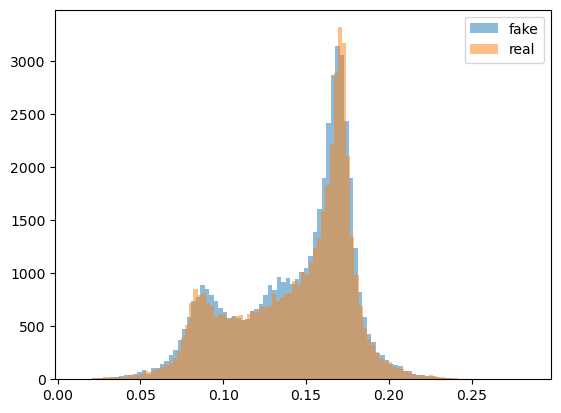

In [73]:
import matplotlib.pyplot as plt
m_f=mass(fake_scaled[:len(true)].cpu().numpy())
m_t=mass(true[:len(true)][:,:,:3].cpu().numpy())
plt.hist(m_f, bins=100, alpha=0.5, label="fake")
plt.hist(m_t, bins=100, alpha=0.5, label="real")
plt.legend()

# CaloChallenge



In [1]:
import copy
import math
import traceback

import hist
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from hist import Hist
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MinMaxScaler, PowerTransformer,
                                   StandardScaler)
from torch.nn import functional as FF
from torch.nn.utils import spectral_norm, weight_norm
from torch.nn.utils.rnn import pad_sequence
# from comet_ml import Experiment
from torch.nn.utils.weight_norm import WeightNorm
from torch.optim.swa_utils import SWALR, AveragedModel
from torch.utils.data import BatchSampler, DataLoader, Dataset, Sampler
from tqdm import tqdm

import wandb
from helpers import (MultiheadL2Attention, WeightNormalizedLinear,
                     plotting_point_cloud)
#from preprocess import ScalerBase,DQ,LogitTransformer
from preprocess_new import *
from preprocess_new import (DQ, DQLinear, LogitTransformer, ScalerBaseNew,
                            SqrtTransformer)
from fit import MDMA
from models import Disc, Gen

def get_hists(bins,mins,maxs,calo=False):
    hists={}
    hists["hists_real"] = []
    hists["hists_fake"] = []


    if calo:
        hists["weighted_hists_real"] = []
        hists["weighted_hists_fake"] = []
        hists["response_real"]=hist.Hist(hist.axis.Regular(100, 0.6, 1.1))
        hists["response_fake"]=hist.Hist(hist.axis.Regular(100, 0.6, 1.1))

        hists["hists_real"].append(hist.Hist(hist.axis.Regular(100, 0, 6000)))
        hists["hists_fake"].append(hist.Hist(hist.axis.Regular(100, 0, 6000)))

        for n in bins[1:]:
            hists["hists_real"].append(hist.Hist(hist.axis.Integer(0, n)))
            hists["hists_fake"].append(hist.Hist(hist.axis.Integer(0, n)))
        for n in bins[1:]:
            hists["weighted_hists_real"].append(hist.Hist(hist.axis.Integer(0, n)))
            hists["weighted_hists_fake"].append(hist.Hist(hist.axis.Integer(0, n)))
    else:
            for n,mi,ma in zip(bins,mins,maxs):
                hists["hists_real"].append(hist.Hist(hist.axis.Regular(n,mi, ma)))
                hists["hists_fake"].append(hist.Hist(hist.axis.Regular(n,mi, ma)))
    return hists



#from fit import MDMA
#from models import Gen,Disc
from dataloader_calo import PointCloudDataloader
def setup_model(config,data_module=None,model=False):
    if not model:
        model = MDMA(**config)
    if config["dataset"]=="calo":
        model.bins=[600,config["num_z"],config["num_alpha"],config["num_R"]]
        model.num_z, model.num_alpha, model.num_R = config["num_z"], config["num_alpha"], config["num_R"]
        model.E_loss=config["E_loss"]
        model.pos_loss=config["pos_loss"]
        model.lambda_gp=config["lambda_gp"]
        model.lambda_response=config["lambda_response"]
        model.min_weighted_w1p=0.1
        model.min_w1p=0.1
        model.minE=0.01
        model.scaler = data_module.scaler
        model.n_dim = 4
        model.power_lambda = model.scaler.transfs[0].lambdas_[0]
        model.mean = model.scaler.transfs[0]._scaler.mean_[0]
        model.scale = model.scaler.transfs[0]._scaler.scale_[0]
        model.pos_mean = torch.tensor(model.scaler.transfs[1].steps[2][1].mean_).cuda()
        model.pos_scale = torch.tensor(model.scaler.transfs[1].steps[2][1].scale_).cuda()
        model.pos_max_scale = torch.tensor(model.scaler.transfs[1].steps[0][1].scale_).cuda()
        model.pos_min = torch.tensor(model.scaler.transfs[1].steps[0][1].min_).cuda()
        if config["dataset"]=="calo":
                    model.power_lambda=model.scaler.transfs[0].lambdas_[0]
                    model.mean=model.scaler.transfs[0]._scaler.mean_[0]
                    model.scale=model.scaler.transfs[0]._scaler.scale_[0]
    else:
        model.bins=[100,100,100]
        model.n_dim = 3
        model.scaler=data_module.scaler
        model.w1m_best=0.01
        model.min_pt=data_module.min_pt
        model.max_pt=data_module.max_pt
    model.i=0
    model.loss = losses.hinge if config["gan"] == "hinge" else losses.wasserstein if config["gan"] == "wgan" else losses.least_squares
    model.gp = config["gp"]
    model.d_loss_mean=None
    model.g_loss_mean=None
    if config["dataset"]=="jet":
        model.scaled_mins=torch.tensor(data_module.mins)
        model.scaled_maxs=torch.tensor(data_module.maxs)
    else:
        model.scaled_mins=torch.zeros(4).cuda()
        model.scaled_maxs=torch.tensor([1e9]+model.bins[1:]).cuda()
    model.swa=False
    return model

import yaml

import losses

NAME="calo"
run="v0mdo0hz"
ckpt="/gpfs/dust/maxwell/user/kaechben/calochallenge/MDMA_calo/83n3r9n7/checkpoints/epoch=294-w1p=0.00045-weighted_w1p=0.00057.ckpt"
ckpt="/gpfs/dust/maxwell/user/kaechben/calochallenge/MDMA_calo/fc715xzn/checkpoints/epoch=416-w1p=0.00038-weighted_w1p=0.00039.ckpt"
ckpt="/gpfs/dust/maxwell/user/kaechben/calochallenge/MDMA_calo/v0mdo0hz/checkpoints/epoch=486-w1p=0.00040-weighted_w1p=0.00051.ckpt"
config=yaml.load(open("default_{}.yaml".format(NAME)),Loader=yaml.FullLoader)
api=wandb.Api()
run=api.run(f"kaechben/MDMA_{NAME}/{run}")
config=run.config
config["L2"]=True
model=MDMA.load_from_checkpoint(ckpt,**config)
torch.set_float32_matmul_precision('medium' )
data_module = PointCloudDataloader(**config)
data_module.setup("train")

state_dict=torch.load(ckpt,map_location="cpu")
config.update(**state_dict["hyper_parameters"])
config["lr"]*=0.01


model=setup_model(config,data_module,model)
model.swa=config["start_swa"]

model.load_datamodule(data_module)

#loop once through dataloader to find mins and maxs to clamp during training
mins=torch.ones(config["n_dim"]).unsqueeze(0)
maxs=torch.ones(config["n_dim"]).unsqueeze(0)
n=[]
for i in data_module.train_dataloader():
    mins=torch.min(torch.cat((mins,i[0][~i[1]].min(0,keepdim=True)[0]),dim=0),dim=0)[0].unsqueeze(0)
    maxs=torch.max(torch.cat((maxs,i[0][~i[1]].max(0,keepdim=True)[0]),dim=0),dim=0)[0].unsqueeze(0)
    n.append((~i[1]).sum(1))
model.maxs=maxs.cuda()
model.mins=mins.cuda()
model.avg_n=torch.cat(n,dim=0).float().cuda().mean()
model.gen_net.avg_n=torch.cat(n,dim=0).float().cuda().mean()
model.dis_net.avg_n=torch.cat(n,dim=0).float().cuda().mean()

/gpfs/dust/maxwell/user/kaechben/.conda/envs/torch_wandb/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/dust/maxwell/user/kaechben/.conda/envs/torch_w ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/dust/maxwell/user/kaechben/.conda/envs/torch_wandb/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless th

Validation DataLoader 0: 100%|██████████| 1563/1563 [01:16<00:00, 20.45it/s]


Traceback (most recent call last):
  File "/home/kaechben/MDMACalo/fit.py", line 376, in calo_evaluation
    self.plot.plot_calo(self.hists_fake, self.hists_real, weighted=False)
  File "/home/kaechben/MDMACalo/helpers.py", line 295, in plot_calo
    self.summary.log_image("{}ratio".format("weighted " if weighted else "unweighted "), [fig],self.step)
AttributeError: 'CSVLogger' object has no attribute 'log_image'


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        features/R         │   0.000626231201402671    │
│    features/R_weighted    │   0.000626231201402671    │
│      features/alpha       │   5.887628534302896e-05   │
│  features/alpha_weighted  │   5.887628534302896e-05   │
│        features/z         │   0.0009051689982272028   │
│    features/z_weighted    │   0.0009051689982272028   │
│        features_E         │   5.193991887832428e-05   │
│          min_w1p          │  0.00041055410096280673   │
│     min_weighted_w1p      │   0.0005300921616576342   │
│            w1p            │  0.00041055410096280673   │
│       weighted_w1p        │   0.0005300921616576342   │
│        weighted_z         │   0.0009051689982272028   │
└───────────────────────────┴───────────────────────────┘

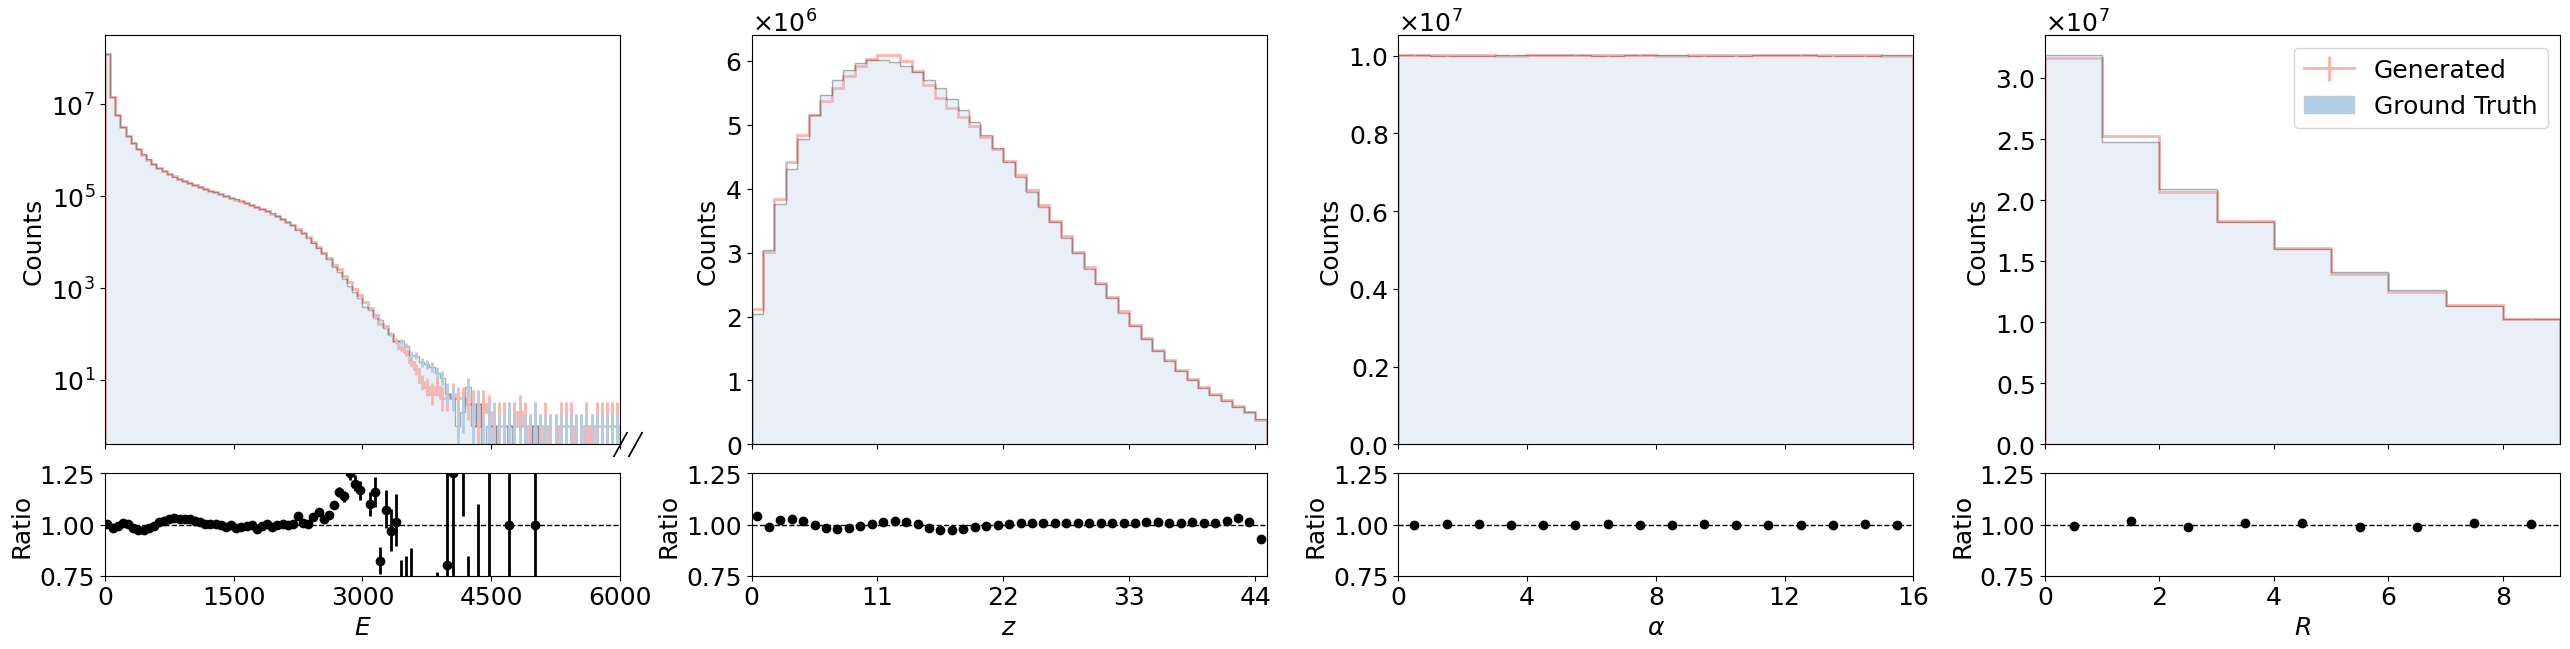

In [2]:

%matplotlib inline
torch.set_float32_matmul_precision('medium' )
from preprocess_new import LogitTransformer, ScalerBaseNew,DQLinear, Cart, SqrtTransformer
config["augmentation"]=False
trainer = pl.Trainer(devices=1,accelerator="gpu")
model.load_datamodule(data_module)
fakes=[]
conds=[]
masks=[]
batches=[]
trainer.validate(model,dataloaders=data_module.val_dataloader(),verbose=True)
batches.extend(model.batch)
fakes.extend(model.fake)
conds.extend(model.conds)
masks.extend(model.masks)

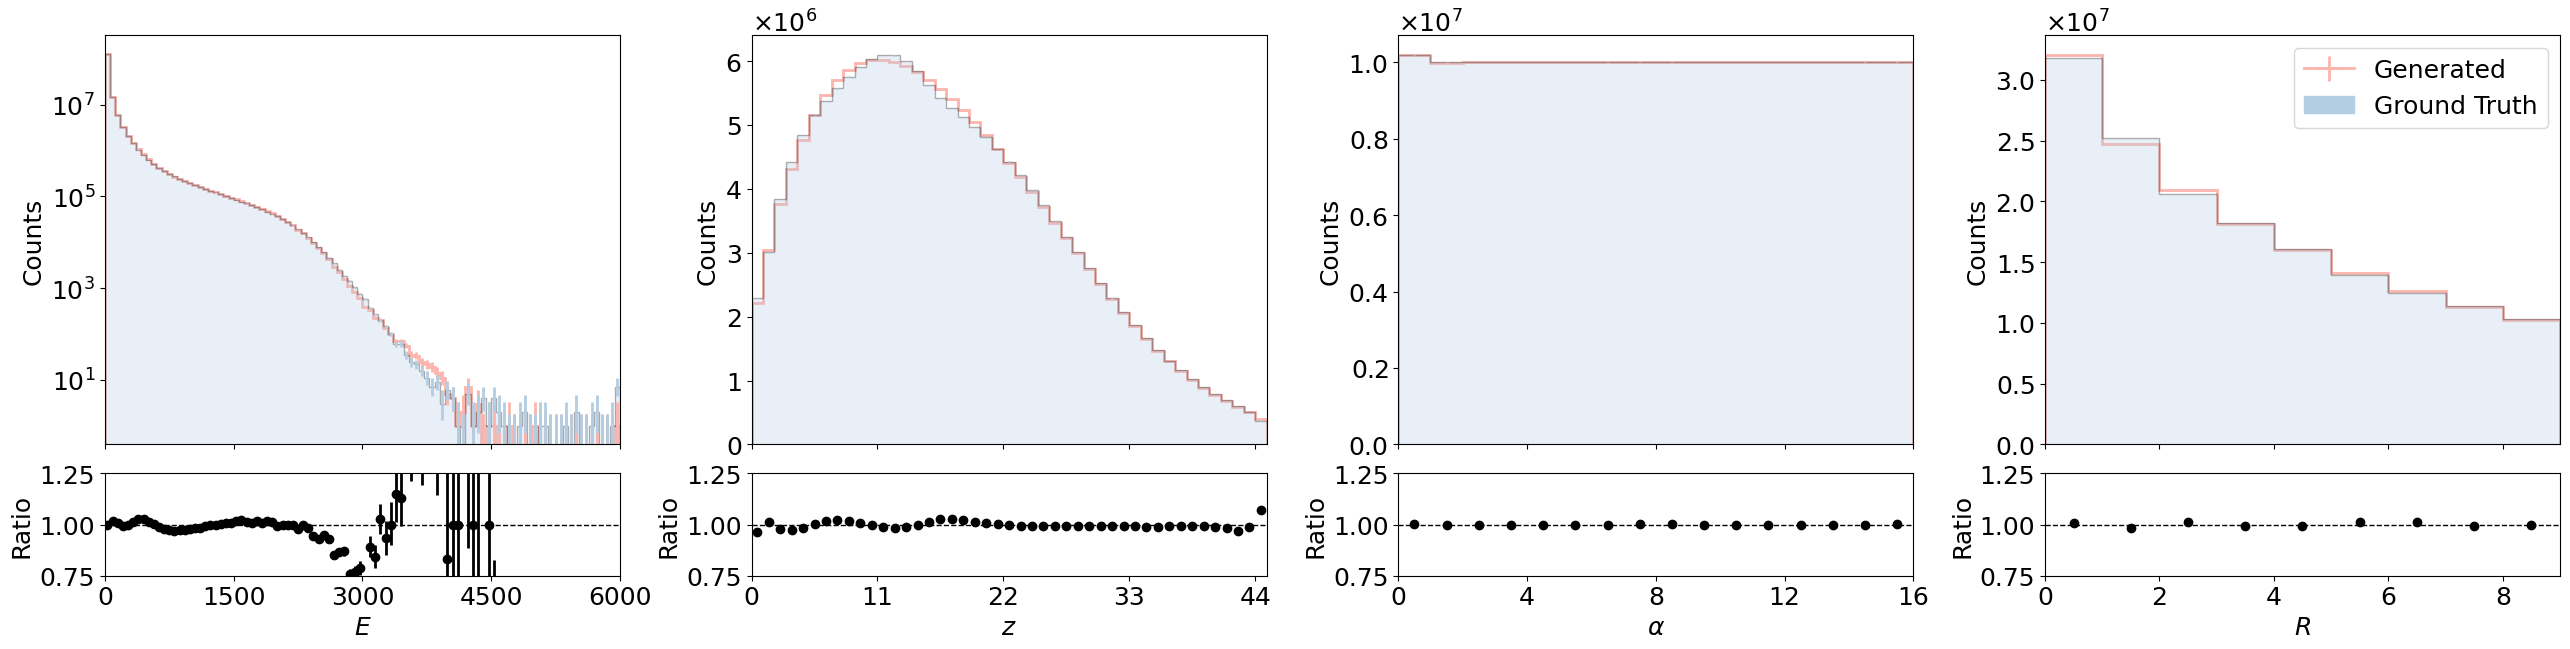

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
def plot_hists(h_real,h_fake,figsize,alpha):
        k=0
        fig,ax=plt.subplots(2,4 ,gridspec_kw={'height_ratios': [4, 1]},figsize=figsize,sharex="col")
       
        cols=["E","z","alpha","R"]
        names=[r"$E$",r"$z$",r"$\alpha$",r"$R$"]
        leg=-1
        for v,name in zip(cols,names):
            main_ax_artists, sublot_ax_arists = h_real[k].plot_ratio(
                h_fake[k],
                ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
                rp_ylabel=r"Ratio",
                bar_="blue",
                rp_num_label="Generated",
                rp_denom_label="Ground Truth",
                rp_uncert_draw_type="line",  # line or bar
            )
            ax[0,k].set_xlabel("")
            ax[0,k].patches[1].set_fill(True)
            ax[0,k].ticklabel_format(axis="y",style="scientific",scilimits=(-3,3),useMathText=True)
            ax[0,k].patches[1].set_fc(sns.color_palette()[1])
            ax[0,k].patches[1].set_edgecolor("black")
            ax[0,k].patches[1].set_alpha(alpha)
            ax[1,k].set_xlabel(name)
            ax[0,k].set_ylabel("Counts" )
            ax[1,k].set_ylabel("Ratio")
            if k==0:
                  ax[0,k].set_yscale("log")
            ax[0,k].patches[0].set_lw(2)
            ax[0,k].get_legend().remove()
            
            xticks=[int(h_real[k].axes[0].edges[-1]//4*i) for i in range(0,int(5))]

            ax[1,k].set_xticks(np.array(xticks),np.array(xticks))
            ax[0,k].set_xticks(np.array(xticks))
            

            ax[1,k].set_ylim(0.75,1.25)
            k+=1
      
        ax[0,leg].legend(loc="best",fontsize=18)
        handles, labels = ax[0,leg].get_legend_handles_labels()
        handles[1]=mpatches.Patch(color=sns.color_palette()[1], label='The red data')
        ax[0,leg].legend(handles, labels)
        plt.tight_layout(pad=0.2)
        plt.savefig("calo.pdf",format="pdf")
        plt.show()

        plt.close()
fake=torch.cat([x.reshape(-1,4) for x in model.fake])[:]
true=torch.cat([x.reshape(-1,4) for x in model.batch])[:]
# fake=torch.clamp(fake,model.scaled_mins.cpu(),model.scaled_maxs.cpu()-1)
# true=torch.clamp(true,model.scaled_mins.cpu(),model.scaled_maxs.cpu()-1)

mins=torch.min(torch.cat((fake.reshape(-1,4),true.reshape(-1,4))),dim=0)[0]
maxs=torch.max(torch.cat((fake.reshape(-1,4),true.reshape(-1,4))),dim=0)[0]
fake[...,0]=torch.clamp(fake[...,0],min=mins[0],max=true[:,0].max()*0.999)
true[...,0]=torch.clamp(true[...,0],min=mins[0],max=true[:,0].max()*0.999)

hists=get_hists(config["bins"],mins,maxs,calo=model.name=="calo")

for var in range(4):
    hists["hists_real"][var].fill(torch.clamp(true,mins,maxs).reshape(-1,4)[:,var].cpu().numpy())
    hists["hists_fake"][var].fill(torch.clamp(fake,mins,maxs).reshape(-1,4)[:,var].cpu().numpy())

plot_hists(hists["hists_real"],hists["hists_fake"],figsize=(4*6.4,6.4),alpha=model.plot.alpha)


In [3]:
import torch_scatter
from math import prod
def convert_4d_indices_to_1d(indices, dims):
    # indices is a tensor of shape [num_indices, 4]
    # dims is the shape of the original tensor (e.g., [dim0, dim1, dim2, dim3])
    assert len(dims) == 4, "dims must be length 4"
    assert indices.shape[1] == 4, "indices must be 2D with second dimension 4"
    indices_1d = indices[:, 0] * dims[1] * dims[2] * dims[3] + indices[:, 1] * dims[2] * dims[3] + indices[:, 2] * dims[3] + indices[:, 3]
    return indices_1d
def complement(t1,t2):
    combined = torch.cat((t1, t2))
    uniques, counts = combined.unique(return_counts=True)
    difference = uniques[counts == 1]
    # intersection = uniques[counts > 1]
    return difference
def complement_idx(idx, dim):
    """
    Compute the complement: set(range(dim)) - set(idx).
    idx is a multi-dimensional tensor, find the complement for its trailing dimension,
    all other dimension is considered batched.
    Args:
        idx: input index, shape: [N, *, K]
        dim: the max index for complement
    """
    a = torch.arange(dim, device=idx.device)
    ndim = idx.ndim
    dims = idx.shape
    n_idx = dims[-1]
    dims = dims[:-1] + (-1, )
    for i in range(1, ndim):
        a = a.unsqueeze(0)
    a = a.expand(*dims)
    masked = torch.scatter(a, -1, idx, 0)
    compl, _ = torch.sort(masked, dim=-1, descending=False)
    compl = compl.permute(-1, *tuple(range(ndim - 1)))
    compl = compl[n_idx:].permute(*(tuple(range(1, ndim)) + (0,)))
    return compl
def voxelize(batch,mask,cond):
    empty = torch.zeros((batch.shape[0],*dims), dtype=batch.dtype, device=batch.device)
    # Get the valid hits
    valid_hits = batch[~mask]
    valid_coordinates=valid_hits[:,1:].long().t()
    shower_index=torch.arange(batch.shape[0]).repeat_interleave((~mask).float().sum(1).reshape(-1).int())

    indices=torch.cat((shower_index.unsqueeze(1),valid_coordinates.t()),dim=1)
    moritz=torch.arange(batch.shape[0]*dims[0]*dims[1]*dims[2]).reshape(*empty.shape)
    scatter_index=moritz[indices[...,0],indices[...,1],indices[...,2],indices[...,3]]

    vox=torch_scatter.scatter_add(src=valid_hits[:,0], index=scatter_index,dim_size=prod(dims)*batch.shape[0])
    return vox.reshape(batch.shape[0],*dims)
fake=[]
conds=[]
batches=[]
dims=(model.num_z,model.num_alpha,model.num_R)
for temp,mask,cond in zip(model.fake,model.masks,model.conds):
    x=temp.clone()
    x[...,1:]=torch.clamp(x[...,1:].cpu(),torch.zeros(3).cpu(),torch.tensor([model.num_z-1,model.num_alpha-1,model.num_R-1],device=temp.device).cpu())
    vox=voxelize(x.cpu(),mask.cpu(),cond.cpu())
    fake.append(vox)
    conds.append(cond[...,0].cpu()) 
for temp,mask,cond in zip(model.batch,model.masks,model.conds):
    x=temp.clone()
    x[...,1:]=torch.clamp(x[...,1:].cpu(),torch.zeros(3).cpu(),torch.tensor([model.num_z-1,model.num_alpha-1,model.num_R-1],device=temp.device).cpu())
    vox=voxelize(x.cpu(),mask.cpu(),cond.cpu())
    batches.append(vox)
    conds.append(cond[...,0].cpu()) 

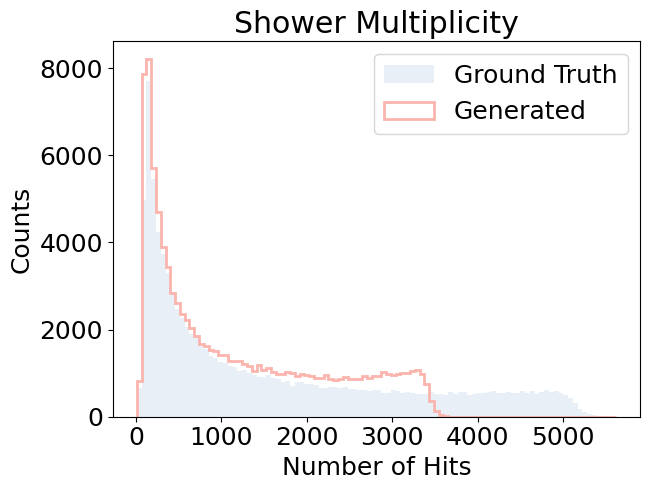

In [4]:
n_fake=(torch.cat(fake).reshape(-1,model.num_z*model.num_alpha*model.num_R)>0).sum(1)
n_real=(torch.cat(batches).reshape(-1,model.num_z*model.num_alpha*model.num_R)>0).sum(1)
_,b,_=plt.hist(n_real.cpu().numpy(),label="Ground Truth",bins=100,alpha=0.3,color="C1")
plt.hist(n_fake.cpu().numpy(),label="Generated",bins=b,alpha=1,color="C0",histtype="step",lw=2)


plt.legend()
plt.title("Shower Multiplicity")
plt.xlabel("Number of Hits")
plt.ylabel("Counts")
plt.tight_layout(pad=0.2)
plt.savefig("calo_n.pdf",format="pdf")



In [10]:
torch.cat(fake)

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 7.8242e-01],
          [0.0000e+00, 0.0000e+00, 4.6921e+01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 1.2549e+01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 6.3295e+00, 0.0000e+00,  ..., 0.0000e+00,
           1.5824e+02, 2.1415e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[4.8771e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           1.8903e+00, 0.0000e+00],
          [2.7756e+01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 1.3704e+01, 0.0000e+00,  ..., 1.5607

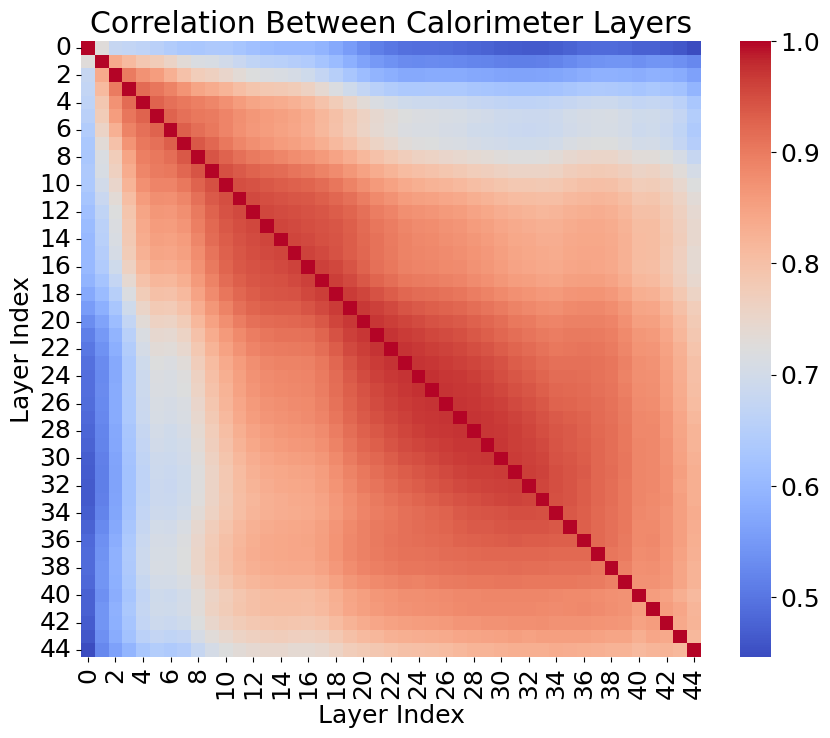

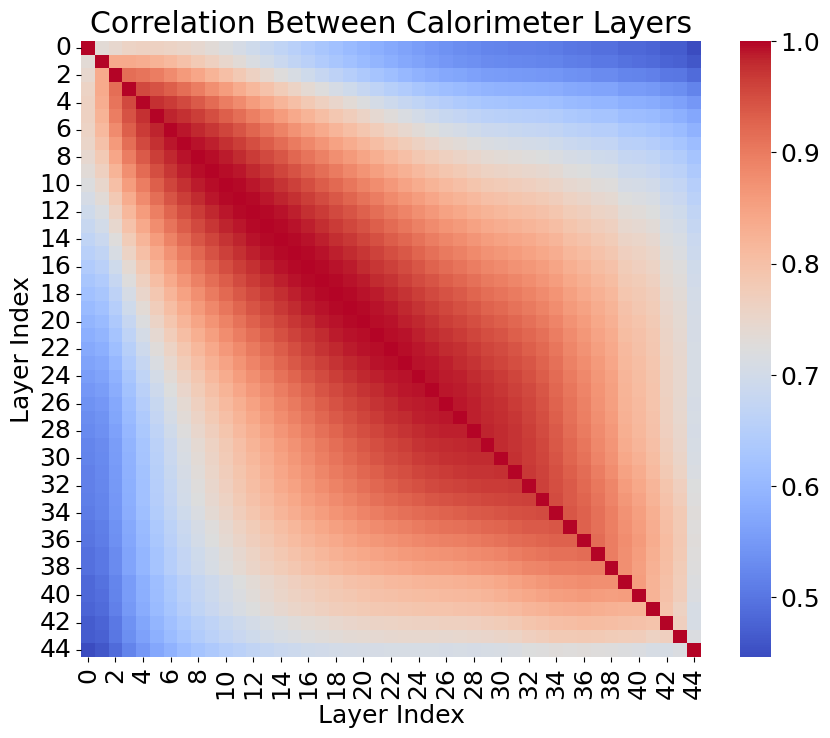

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate a 4D tensor for demonstration
# tensor = np.random.rand(batch_size, 45, 16, 9)

def compute_correlation_matrix(tensor):
    # Sum over the angular and radial layers
    summed_tensor = tensor.sum(axis=(2, 3))
    
    # Compute the correlation matrix across the batch dimension
    correlation_matrix = np.corrcoef(summed_tensor, rowvar=False)
    
    return correlation_matrix

# Compute the correlation matrix
correlation_matrix = compute_correlation_matrix(torch.cat(fake).numpy())

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Between Calorimeter Layers")
plt.xlabel("Layer Index")
plt.ylabel("Layer Index")
plt.show()
correlation_matrix = compute_correlation_matrix(torch.cat(batches).numpy())

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Between Calorimeter Layers")
plt.xlabel("Layer Index")
plt.ylabel("Layer Index")
plt.show()

In [29]:
%matplotlib inline
torch.set_float32_matmul_precision('medium' )
from preprocess_new import LogitTransformer, ScalerBaseNew,DQLinear, Cart, SqrtTransformer
config["augmentation"]=False
trainer = pl.Trainer(devices=1,accelerator="gpu")
model.load_datamodule(data_module)
trainer.validate(model,dataloaders=data_module.val_dataloader(),verbose=True)

/beegfs/desy/user/kaechben/.conda/envs/torch_wandb/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /beegfs/desy/user/kaechben/.conda/envs/torch_wandb/l ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2b4254888af0>
Traceback (most recent call last):
  File "/beegfs/desy/user/kaechben/.conda/envs/torch_wandb/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/beegfs/desy/user/kaechben/.conda/envs/torch_wandb/lib/python3.10/site-packages/torch/utils/da

Validation DataLoader 0:  10%|█         | 162/1563 [00:08<01:10, 19.97it/s]

/beegfs/desy/user/kaechben/.conda/envs/torch_wandb/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [13]:
import h5py 
# E=torch.cat(conds)[:100000,0]
# fake=torch.cat(fake)[:100000]
with h5py.File("/beegfs/desy/user/kaechben/calochallenge/MDMA_dataset_2_new.hdf5".format("MDMA"), "w") as h5_file:
    
    N = len(fake) # find the length of my dataset
    h5_file.create_dataset('incident_energies', shape=(N, ), dtype=np.float64, data=(E+10).exp().double().cpu().numpy())
    h5_file.create_dataset('showers', shape=(N,fake.shape[3]*fake.shape[1]*fake.shape[2] ), dtype=np.float64, data=fake.double().reshape(-1,fake.shape[3]*fake.shape[1]*fake.shape[2]).numpy(), )#compression="gzip", compression_opts=9

In [10]:
# 
torch.cat(fake).shape

torch.Size([100000, 45, 16, 9])

conds